In [4]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter
from scipy.signal import welch, stft, spectrogram, get_window
from scipy.signal.windows import hann
import math
import time
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt

In [152]:
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a

def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)

In [158]:
fs = 6000  # Sampling frequency in Hz
low_cut_off = 50
high_cut_off = 1000
filter_order = 4
filter_type =  "bandpass"  #"bandpass"

rep=3

b,a = build_filter((low_cut_off, high_cut_off), fs, filter_type, filter_order)

In [159]:

data_path = f"../../data/TKA_data/op/tka_op_{rep}.csv"
op = pd.read_csv(data_path)

data_path = f"../../data/TKA_data/un_op/tka_un_op_{rep}.csv"
u_op = pd.read_csv(data_path)

op_x = filter_signal(b,a, op['x'], "filtfilt")#amplitude_normal(op['x']),"filtfilt")
op_y = filter_signal(b,a, op['y'], "filtfilt")#amplitude_normal(op['y']), "filtfilt")
op_z = filter_signal(b,a, op['z'], "filtfilt")#amplitude_normal(op['z']), "filtfilt")
op_mag = filter_signal(b,a, op['mag'], "filtfilt") #amplitude_normal(op['mag']), "filtfilt")

u_op_x = filter_signal(b,a,  u_op['x'], "filtfilt")#amplitude_normal(u_op['x']), "filtfilt")
u_op_y = filter_signal(b,a, u_op['y'], "filtfilt")#amplitude_normal(u_op['y']), "filtfilt")
u_op_z = filter_signal(b,a, u_op['z'], "filtfilt")#amplitude_normal(u_op['z']), "filtfilt")
u_op_mag = filter_signal(b,a, u_op['mag'], "filtfilt")#amplitude_normal(u_op['mag']), "filtfilt")

In [169]:
# compute short time fourier transform

#STFT
segment_length = 150  # Number of samples per segment
overlap = 100  # Overlap of 100 samples
window = hann(segment_length)

op_f, op_t, op_Zxx = stft(op_mag, fs=fs, window=window, nperseg=segment_length, noverlap=overlap)
u_op_f, u_op_t, u_op_Zxx = stft(u_op_mag, fs=fs, window=window, nperseg=segment_length, noverlap=overlap)
# compute power from stft
op_pwr = np.abs(op_Zxx)**2
u_op_pwr = np.abs(u_op_Zxx)**2

# F Bands
band1 = (50, 250)  # Frequency band 1: 50–250 Hz
band2 = (250, 450)  # Frequency band 2: 250–450 Hz

# Find indices corresponding to the desired frequency bands
op_band1_indices = np.logical_and(op_f >= band1[0], op_f < band1[1])
op_band2_indices = np.logical_and(op_f >= band2[0], op_f < band2[1])

u_op_band1_indices = np.logical_and(u_op_f >= band1[0], u_op_f < band1[1])
u_op_band2_indices = np.logical_and(u_op_f >= band2[0], u_op_f < band2[1])

# Sum the power in the specified bands
op_P1 = np.sum(op_pwr[op_band1_indices, :], axis=0)
op_P2 = np.sum(op_pwr[op_band2_indices, :], axis=0)

u_op_P1 = np.sum(u_op_pwr[u_op_band1_indices, :], axis=0)
u_op_P2 = np.sum(u_op_pwr[u_op_band2_indices, :], axis=0)

total_op_P1 = np.sum(op_pwr[op_band1_indices, :])  # Total power in 50-250 Hz across all time
total_op_P2 = np.sum(op_pwr[op_band2_indices, :])  # Total power in 250-450 Hz across all time
total_u_op_P1 = np.sum(u_op_pwr[u_op_band1_indices, :])
total_u_op_P2 = np.sum(u_op_pwr[u_op_band2_indices, :])
# Print the total power in each band
print(f"Total Power in 50-250 Hz (op P1): {total_op_P1} (u_op P1): {total_u_op_P1}")
print(f"Total Power in 250-450 Hz (op P2): {total_op_P2} (u_op P2): {total_u_op_P2}")

#print(f"op P1: {op_P1}, op P2: {op_P2}")
#print(F"u_up P1: {u_op_P1}, u_op P2: {u_op_P2}")

op_avg_pwr = np.mean(op_pwr, axis=1)
u_op_avg_pwr = np.mean(u_op_pwr, axis=1)

Total Power in 50-250 Hz (op P1): 0.0682438526531352 (u_op P1): 0.03692208807645568
Total Power in 250-450 Hz (op P2): 0.035733556515340645 (u_op P2): 0.03899794835701495
[1.35801716e-07 1.43633781e-06 4.51992336e-06 6.38198249e-06
 7.12926299e-06 5.95220794e-06 4.46341465e-06 3.74702419e-06
 3.52231403e-06 2.99385700e-06 2.43358226e-06 2.19841073e-06
 2.13282241e-06 2.11896722e-06 2.06964434e-06 1.89690401e-06
 1.75402429e-06 1.70206183e-06 1.81506535e-06 1.67481212e-06
 1.37605181e-06 1.19022835e-06 9.84210376e-07 7.38901329e-07
 5.76900591e-07 4.48163479e-07 3.10265195e-07 1.43859522e-07
 7.88235560e-08 4.33345653e-08 2.19915737e-08 1.14913311e-08
 5.66573276e-09 2.76643622e-09 1.35354096e-09 6.81011259e-10
 3.68679029e-10 2.05057222e-10 9.04074351e-11 4.53054481e-11
 2.46063148e-11 1.41155623e-11 8.82990310e-12 6.18604759e-12
 4.79205381e-12 3.86300908e-12 3.30894937e-12 2.99450303e-12
 2.77294162e-12 2.57997072e-12 2.41761942e-12 2.28774745e-12
 2.18131612e-12 2.08309151e-12 1.992

(50.0, 1000.0)

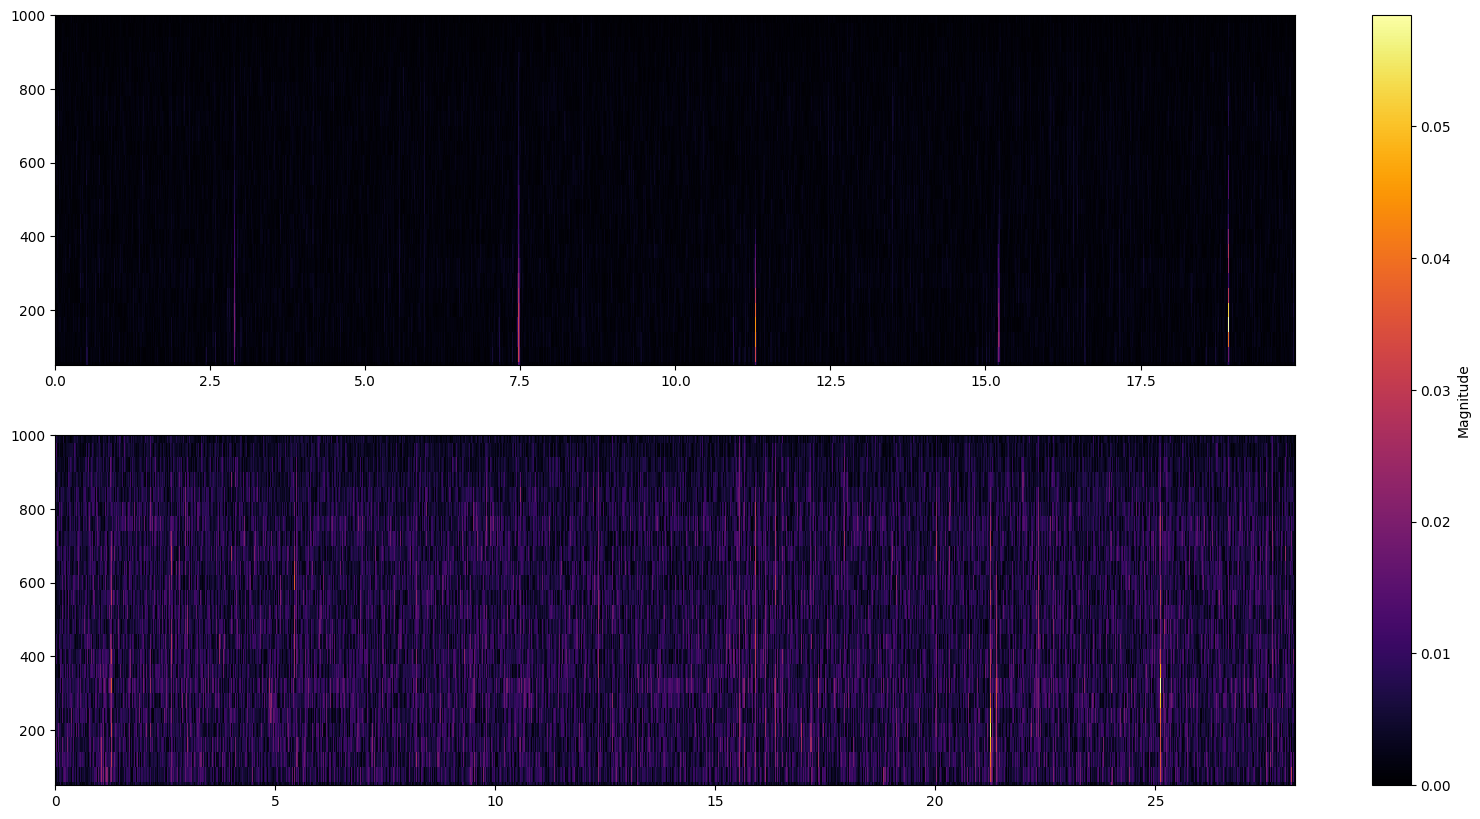

In [157]:
# plot the spectograms for op and u_op stft
fig, ax = plt.subplots(2,1, figsize=(20, 10))
#np.abs(u_op_Zxx)
cax = ax[0].pcolormesh(op_t, op_f, np.abs(op_Zxx), shading='auto', cmap="inferno")
ax[1].pcolormesh(u_op_t, u_op_f, np.abs(u_op_Zxx), shading='auto', cmap="inferno")

fig.colorbar(cax, ax=ax, label='Magnitude')

ax[0].set_ylim(50, 1000)
ax[1].set_ylim(50, 1000)


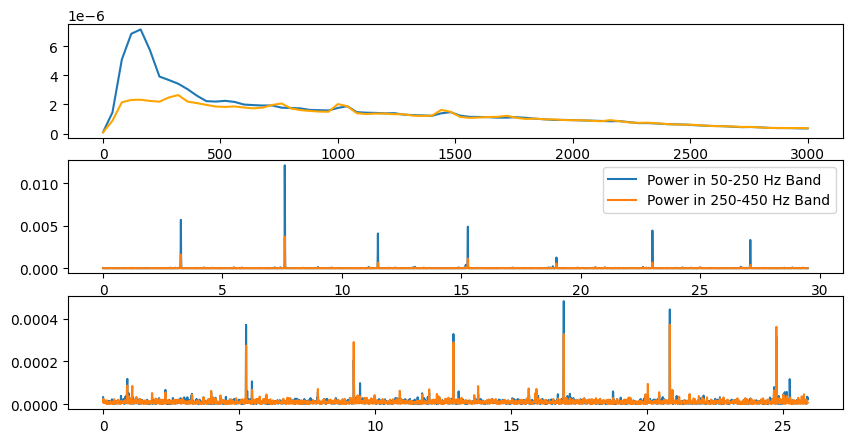

In [141]:
#plot the power spectrums
# plot the spectograms for op and u_op stft
fig, ax = plt.subplots(3,1, figsize=(10, 5))

ax[0].plot(op_f, op_avg_pwr,  label='Average Power Spectrum')
ax[0].plot(u_op_f, u_op_avg_pwr, color="orange",  label='Average Power Spectrum')

ax[1].plot(op_t, op_P1,  label='Power in 50-250 Hz Band')
ax[1].plot(op_t, op_P2, label='Power in 250-450 Hz Band')

ax[2].plot(u_op_t, u_op_P1)
ax[2].plot(u_op_t, u_op_P2)

ax[1].legend()